In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

In [12]:
df = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\elecproduction.csv", parse_dates=['DATE'])
df.columns = ['Date', 'Electricity']
df = df.sort_values('Date').set_index('Date').asfreq('MS').interpolate()
df.head()

,Electricity
Date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


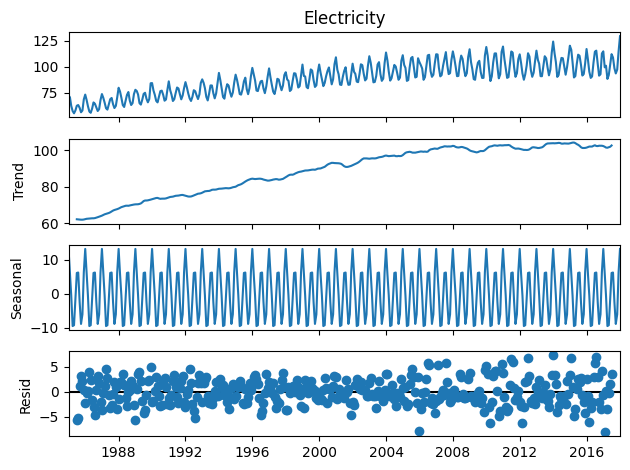

In [3]:
decomposition = seasonal_decompose(df['Electricity'], model='additive', period=12)
decomposition.plot()
plt.show()

In [4]:
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]:.2f}')
    print(f'p-value: {result[1]:.2f}')

adf_test(df['Electricity'])

ADF Statistic: -2.26
p-value: 0.19


In [32]:
def create_features(df, lags=12):
    for lag in range(1, lags+1):
        df[f'lag_{lag}'] = df['Electricity'].shift(lag)
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df.dropna()

df = create_features(df)
df['rolling_mean_7'] = df['Electricity'].rolling(window=7).mean()
df['day'] = df.index.day
df['quarter'] = df.index.quarter
df = df.dropna()
df.head()

,Electricity,Electricity_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,month,year,rolling_mean_7,day,quarter
Date,,,,,,,,,,,,,,,,,,,
1987-09-01,64.1151,-5.9518,70.0669,68.8694,63.8918,58.8734,60.1586,65.6100,70.0620,73.8152,68.1354,59.3417,57.5322,61.0005,9,1987,64.512171,1,3
1987-10-01,60.3789,-3.7362,64.1151,70.0669,68.8694,63.8918,58.8734,60.1586,65.6100,70.0620,73.8152,68.1354,59.3417,57.5322,10,1987,63.764871,1,4
1987-11-01,62.4643,2.0854,60.3789,64.1151,70.0669,68.8694,63.8918,58.8734,60.1586,65.6100,70.0620,73.8152,68.1354,59.3417,11,1987,64.094257,1,4
1987-12-01,70.5777,8.1134,62.4643,60.3789,64.1151,70.0669,68.8694,63.8918,58.8734,60.1586,65.6100,70.0620,73.8152,68.1354,12,1987,65.766300,1,4
1988-01-01,79.8703,9.2926,70.5777,62.4643,60.3789,64.1151,70.0669,68.8694,63.8918,58.8734,60.1586,65.6100,70.0620,73.8152,1,1988,68.048943,1,1


In [34]:
test_size = 24
train, test = df.iloc[:-test_size], df.iloc[-test_size:]

X_train, y_train = train.drop('Electricity', axis=1), train['Electricity']
X_test, y_test = test.drop('Electricity', axis=1), test['Electricity']

In [35]:
param_dist = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False],
}

In [36]:
lr = LinearRegression()
tscv = TimeSeriesSplit(n_splits=5)

random_search = RandomizedSearchCV(lr,
param_dist,
scoring='r2',
cv=tscv,
n_jobs=-1
)

random_search.fit(X_train, y_train)

c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=LinearRegression(), n_jobs=-1,
                   param_distributions={'copy_X': [True, False],
                                        'fit_intercept': [True, False],
                                        'positive': [True, False]},
                   scoring='r2')

In [37]:
best_lr = random_search.best_estimator_

test_preds = best_lr.predict(X_test)

In [40]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred)/y_true)) * 100
    return mae, rmse, mape

mae, rmse, mape = calculate_metrics(y_test, test_preds)
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

MAE: 0.00, RMSE: 0.00, MAPE: 0.00%


In [43]:
last_known_values = df.iloc[-1].drop('Electricity')

future_dates = pd.date_range(start=df.index[-1], periods=60, freq='MS')
future_data = pd.DataFrame(index=future_dates)

for col in X_train.columns:
    future_data[col] = last_known_values[col]

future_predictions = best_lr.predict(future_data)

future_data['Production_Predicted'] = future_predictions

In [44]:
future_predictions

array([129.4048, 129.4048, 129.4048, 129.4048, 129.4048, 129.4048,
       129.4048, 129.4048, 129.4048, 129.4048, 129.4048, 129.4048,
       129.4048, 129.4048, 129.4048, 129.4048, 129.4048, 129.4048,
       129.4048, 129.4048, 129.4048, 129.4048, 129.4048, 129.4048,
       129.4048, 129.4048, 129.4048, 129.4048, 129.4048, 129.4048,
       129.4048, 129.4048, 129.4048, 129.4048, 129.4048, 129.4048,
       129.4048, 129.4048, 129.4048, 129.4048, 129.4048, 129.4048,
       129.4048, 129.4048, 129.4048, 129.4048, 129.4048, 129.4048,
       129.4048, 129.4048, 129.4048, 129.4048, 129.4048, 129.4048,
       129.4048, 129.4048, 129.4048, 129.4048, 129.4048, 129.4048])

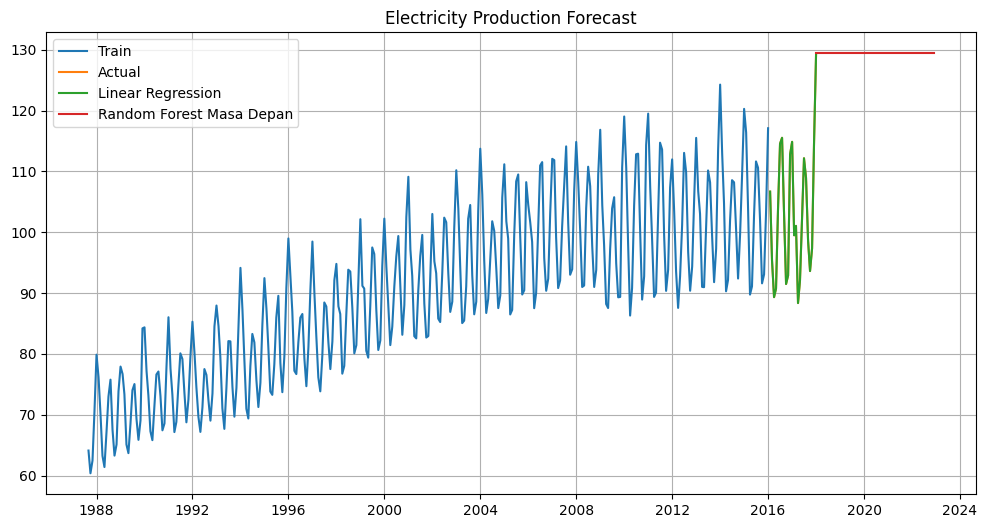

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Electricity'], label='Train')
plt.plot(test.index, y_test, label='Actual')
plt.plot(test.index, test_preds, label='Linear Regression')
plt.plot(future_dates, future_predictions, label='Random Forest Masa Depan')
plt.title('Electricity Production Forecast')
plt.legend()
plt.grid(True)
plt.show()